## Outline of the problem

This goal with building this model is to create a model which would give our sponsors predictive power on the configuration of an eports tournament which give a minimum threshold of required viewers chosen to be 10K (hypothetically cost effective). This variable was chosen as these sponsors will expect a minimum threshold of viewers which running these tournament for it to be cost effective. By incorperating useful predicitors into our model such as, days to run the tournament for, the prize pool amount, location and the month the tournament should be run. By incorporating these predictors it would allow stakeholders to use the model to investigate tournament configurations that would produce a gain in revenue that they might not of otherwise thought of while also ensuring that expected returns are being continued to be met. 


## Module Import

In [388]:
#Import all required pandas modules
import pandas as pd
from sklearn.model_selection import train_test_split
import statsmodels.formula.api as smf
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from statsmodels.graphics import gofplots as sm
import numpy as np
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from scipy import stats
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
import missingno as msno
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import plot_confusion_matrix
import statsmodels.api as sm

## Data Import

In [389]:
pd.reset_option('display.max_rows')
CSdf = pd.read_csv('CSGO.csv')
Dotadf = pd.read_csv('Dota_2.csv')
PUBGdf = pd.read_csv('PUBG.csv')
R6df = pd.read_csv('R6.csv')
RLdf = pd.read_csv('RL.csv')
tournament_df = pd.read_json('tour2.json')
T7df = pd.read_csv('T7.csv')

gamedfs = [CSdf, Dotadf, PUBGdf, R6df, RLdf, T7df]
game_names = ['CSGO', 'D2', 'PUBG', 'R6', 'RL', 'T7' ]



## Dataframe preproccessing

In [390]:
def df_clean(dfs,game_str):
    
    final_games = pd.DataFrame()

    for df, g_str in zip(dfs, game_str):
        df['DateTime'] = pd.to_datetime(df['DateTime'])
        df = df.drop(columns=['Flags', 'Players Trend'], errors='ignore' )
        df = df.dropna(axis=0)
        df.reset_index(drop=True, inplace=True)
        df['Game_gain'] = df['Players'] - df['Players'].shift(1)
        df['Twitch_gain'] = df['Twitch Viewers'] - df['Twitch Viewers'].shift(1)        
        df['Game:'] = g_str
        df['Prev_views'] = df['Twitch Viewers'].shift(1)
        df['Prev_players'] = df['Players'].shift(1)
        
        final_games = final_games.append(df,sort=False)
        final_games.reset_index(drop=True, inplace=True)
    return final_games

figuresdf = df_clean(gamedfs,game_names)


In [391]:
tournament_df = tournament_df.drop(columns=['Currency:', 'Exchange Rate:'], errors='ignore')
tournament_df['Start Date'] = tournament_df['Date:'].str[:10]
tournament_df['End Date'] = tournament_df['Date:'].str[-10:]
tournament_df['Prize Pool'] = tournament_df['Prize Pool:'].apply(lambda x: str(x).split('(')[-1] )
tournament_df['Location:'] = tournament_df['Location:'].apply(lambda x: str(x).split(',')[-1] )
tournament_df['Location:'] = tournament_df['Location:'].str.strip()
tournament_df['Prize Pool'] = tournament_df['Prize Pool'].str.replace(r'\D+', '')
tournament_df = tournament_df.drop(columns=['Date:', 'Prize Pool:'])
tournament_df['End Date'] = pd.to_datetime(tournament_df['End Date'])
tournament_df['Start Date'] = pd.to_datetime(tournament_df['Start Date'])
tournament_df['Prize Pool'] = tournament_df['Prize Pool'].astype(float)
tournament_df['Tour_days'] = (tournament_df['End Date'] - tournament_df['Start Date']).dt.days
drop_tour_locs = {'Offline', 'N/A', 'Asia', 'Southeast Asia', 'South USA', 'Europe', 'Middle East', 'USAs', 'Latin USA', 'Americas', 'Latin America', 'South America', 'Americas'}
tournament_df.drop(tournament_df.loc[tournament_df['Location:'] == drop_tour_locs].index, inplace=True)


game_title_replace = {'Counter-Strike: Global Offensive' : 'CSGO', 'Dota 2' : 'D2', 'PLAYERUNKNOWN’S BATTLEGROUNDS' : 'PUBG', 'Rocket League' : 'RL', 'Tekken 7' : 'T7'}
tournament_df['Game:'] = tournament_df['Game:'].replace(game_title_replace)
tournament_df.drop(tournament_df[tournament_df['Tour_days'] >= 5].index, inplace=True)
tournament_df['Tour_days'] = (tournament_df['Tour_days'] + 1)
tournament_df['DATE'] = [pd.date_range(s, e, freq='d') for s, e in
              zip(pd.to_datetime(tournament_df['Start Date']), pd.to_datetime(tournament_df['End Date']))]

tournament_df = tournament_df.explode('DATE')
tournament_df.drop_duplicates(inplace=True)

In [392]:
#Merge the tournaments data frames and 
final_frame = pd.merge(tournament_df, figuresdf, left_on=['Game:','DATE'], right_on=['Game:','DateTime'], how='inner',copy=False)


In [393]:
#Cleaning up of the location data in the dataframe to group countries into one variable for a given country instead or many. 
rename_locs = {'Germay' : 'Germany', 'Online (Twitch)' : 'Online','online' : 'Online', 'South Africa' : 'SouthA', 'Taipei City': 'Taipei', 'Unites States' : 'USA', 'Europe/Americas/OCE' : 'drop',  'United Kingdom' : 'UK', 'United States' : 'USA', 'United Arab Emirates' : 'UAE', 'Texas' : 'USA', 'Madrid' : 'Spain', '(Spain)' : 'Spain', 'Hong Kong' : 'China', 'America' : 'USA','Philadelphia' : 'USA', 'Sydney' : 'Australia', 'Toronto' : 'USA',  'AMERICAS' : 'USA', 'North America' : 'USA'}
rename_city = {'TX' : 'USA', 'Parc des Expositions de la porte de Versailles' : 'France', 'Dominican Republic' : 'DomPublic', 'Madrid (Spain)' : 'Spain',  'Fresno' : 'USA', 'Al Khobar' : 'Saudi Arabia', 'IL' : 'USA', 'Taipei' : 'Taiwan', 'Taiwan City' : 'Taiwan', 'Chantilly' : 'France', 'Spain Spain' : 'Spain' , 'Kettering' : 'UK', 'Macao' : 'China', 'Berlin' : 'Germany', 'Fersno' : 'USA' , 'Wien' : 'Austria', 'Québec' : 'Canada', 'Saudi arabia' : 'Saudi Arabia', 'Bogotá' : 'Columbia', 'Fukuoka' : 'Japan', 'China (offline)' : 'China',  'NV' : 'USA',  'North USA' : 'USA', 'Colmar' : 'France', 'La Rochelle' : 'France', 'Brussels' : 'Belgium' , 'Copenhagen' : 'Denmark',  'Fredericia' : 'Denmark', 'Seoul' : 'SK', 'South Korea' : 'SK', 'Korea' : 'SK',  'Rome' : 'Italy', 'São Paulo': 'Brazil', 'Dublin' : 'Ireland', 'Jakarta' : 'Indonesia',  'NJ' : 'USA', 'Poitiers' : 'France', 'New Jersey' : 'USA', 'Seattle' : 'USA', 'Santa Ana' : 'USA',   'Dallas' : 'USA', 'CA' : 'USA', 'CT': 'USA', 'Bangkok' : 'Thailand', 'Richmond' : 'USA', 'Tokyo' : 'Japan',  'Sweden.' : 'Sweden', 'MA' : 'USA', 'San Jose' : 'USA', 'MaCanadao' : 'Canada', 'SC' : 'USA', 'Changsha' : 'China', 'Riyadh' : 'Saudi Arabia',  'Florida' : 'USA', 'London' : 'UK' , 'Stockholm Sweden.' : 'Sweden' , 'BC' : 'USA', 'Oslo' : 'Norway', 'MaCanadao' : 'Canada', 'Dubai' : 'UAE' ,'China (offline)' : 'China', 'Birmingham' : 'UK', 'Munich' : 'Germany', 'Pennsylvania' : 'USA' , 'Moscow': 'Russia', 'Elmhurst' : 'USA', 'NA' : 'USA' , 'FL' : 'USA', 'Montreal' : 'Canada', 'Ghent' : 'Belgium' , 'Tennessee' : 'USA' ,  'Barcelona' : 'Spain', 'Shanghai' : 'China', 'California' : 'USA' , 'Zürich' : "Switzerland", 'Mechelen' : 'Belgium', 'GA' : 'Georgia', 'Paris' : 'France',  'Manila' : 'Philippines', 'Chiba': 'Japan', 'Lille' : 'France', 'Flordia' : 'USA', 'Bern' : 'Switzerland', 'Los Angeles' : 'USA', 'San Francisco' : 'USA', 'MaCanadau' : 'Canada' , 'MaCanadao' : 'Canada', 'MaCanadau' : 'Canada', 'Kyiv' : 'Ukraine' , 'ca' : 'Canada'}
final_frame['Location:'] = final_frame['Location:'].replace(rename_locs)
final_frame['Location:'] = final_frame['Location:'].replace(rename_city)
final_frame.drop(final_frame.loc[final_frame['Location:'] == 'drop'].index, inplace=True)
final_frame.drop(final_frame.loc[final_frame['Location:'] == 'Europe'].index, inplace=True)
final_frame.drop(final_frame.loc[final_frame['Location:'] == 'Americas'].index, inplace=True)
final_frame.drop(final_frame.loc[final_frame['Location:'] == 'Offline'].index, inplace=True)
try:
    final_frame = final_frame.groupby(['T,o,u,r'], as_index=False).agg({ 'DateTime' : 'first', 'Tour_days' : 'first','Location:': 'first', 'Game:' : 'first', 'Prize Pool' : 'first', 'Players' : 'first', 'Twitch Viewers' : 'first', 'Game_gain' : 'sum', 'Twitch_gain' : 'sum', 'Prev_views' : 'first', 'Prev_players' : 'first'})
except:
    pass

#Encode the twtich gain column with a binary representation as our taget variables for values over 10k viewers.
final_frame.loc[final_frame['Twitch_gain'] < 10000,'Twitch_gain' ] = 0
final_frame.loc[final_frame['Twitch_gain'] >= 10000, 'Twitch_gain'] = 1
final_frame.drop(columns=['T,o,u,r'], inplace=True, errors='ignore')
# covert dates to month value as it would be a useful predictor in our model
final_frame['DateTime'] = final_frame['DateTime'].dt.month


## Exploratory Date Analyse (EDA)

<AxesSubplot:>

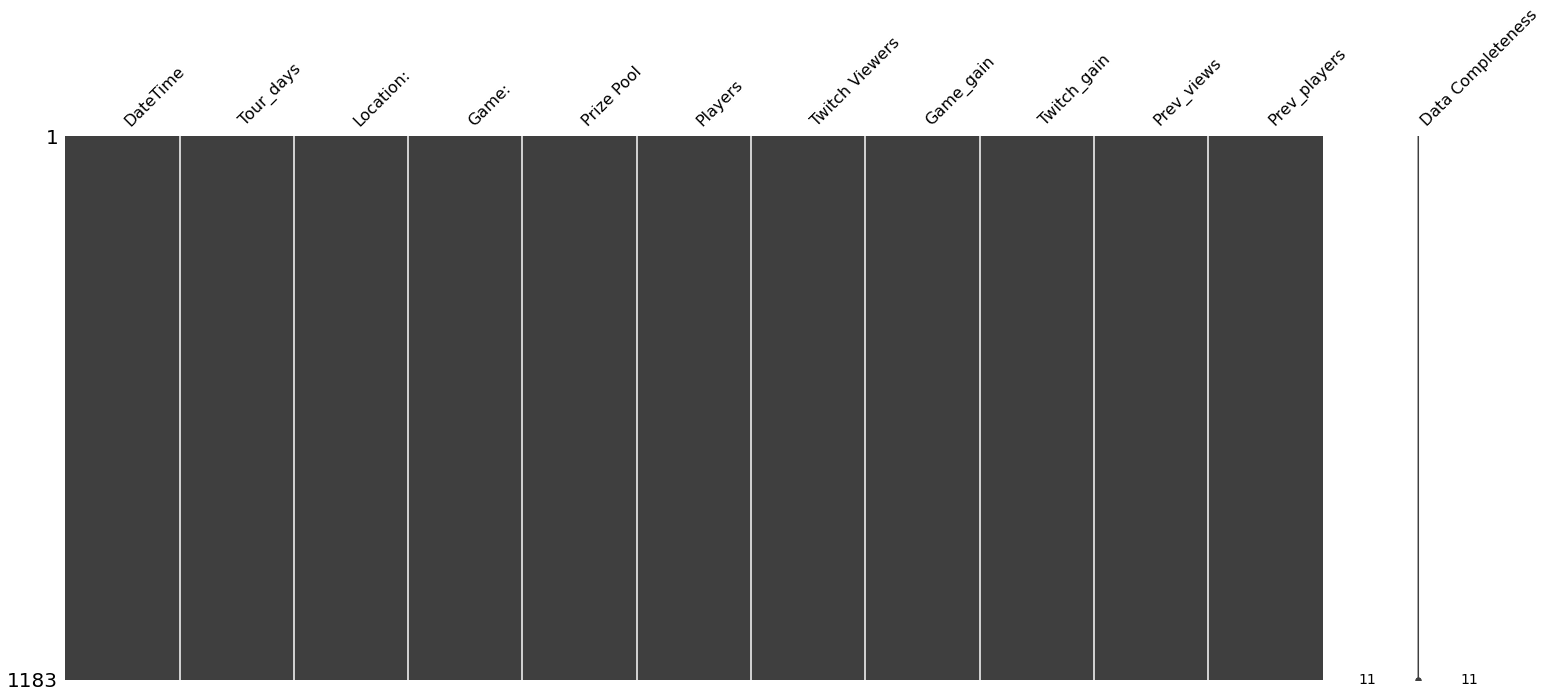

In [394]:
msno.matrix(final_frame, labels=True)

We can see that there are no missing values in your data so no issues there. Next we can split the data into categorical and numerical data for further analysis. 

In [395]:
#Split columns into categorical and Numerical data.
Category_columns = [ 'Tour_days', 'Twitch_gain', 'DateTime']
Numerical_columns = ['Prize Pool', 'Players', 'Twitch Viewers', 'Game_gain', 'Prev_views', 'Prev_players']

array([[<AxesSubplot:title={'center':'Tour_days'}>,
        <AxesSubplot:title={'center':'Twitch_gain'}>],
       [<AxesSubplot:title={'center':'DateTime'}>, <AxesSubplot:>]],
      dtype=object)

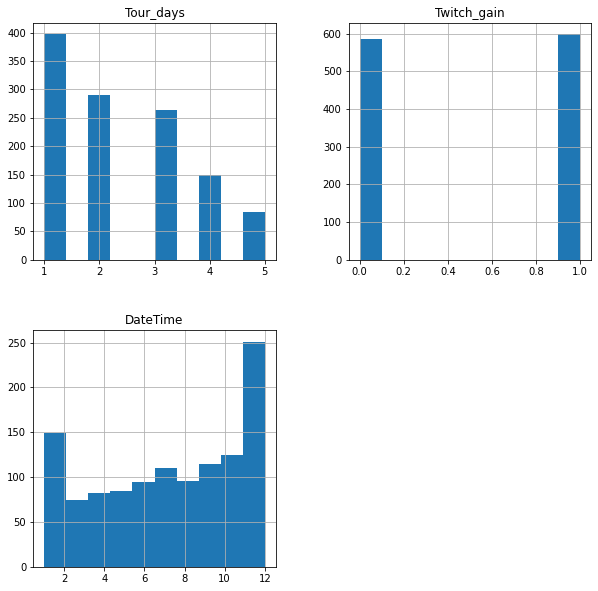

In [396]:

final_frame.hist(column = Category_columns, figsize=(10,10), ylabelsize=10, xlabelsize = 10)


For Datetime we have the expected values of the months within the 1-12 range and more tournaments occuring near the end of the year and in January which is to be expected.
With Twitch gain we have an rougly even distribution of tournaments providing a gain of 10000 viewers and less than 10000 viewers. This would lend itself well to using accuracy as the predictive metric in our model. 
Tour dates we have an obvious trends with longer tournaments being less favourable which is to be expected as they cost more money and tend to be run for only major events which there is fewer of. 

array([[<AxesSubplot:title={'center':'Prize Pool'}>,
        <AxesSubplot:title={'center':'Players'}>],
       [<AxesSubplot:title={'center':'Twitch Viewers'}>,
        <AxesSubplot:title={'center':'Game_gain'}>],
       [<AxesSubplot:title={'center':'Prev_views'}>,
        <AxesSubplot:title={'center':'Prev_players'}>]], dtype=object)

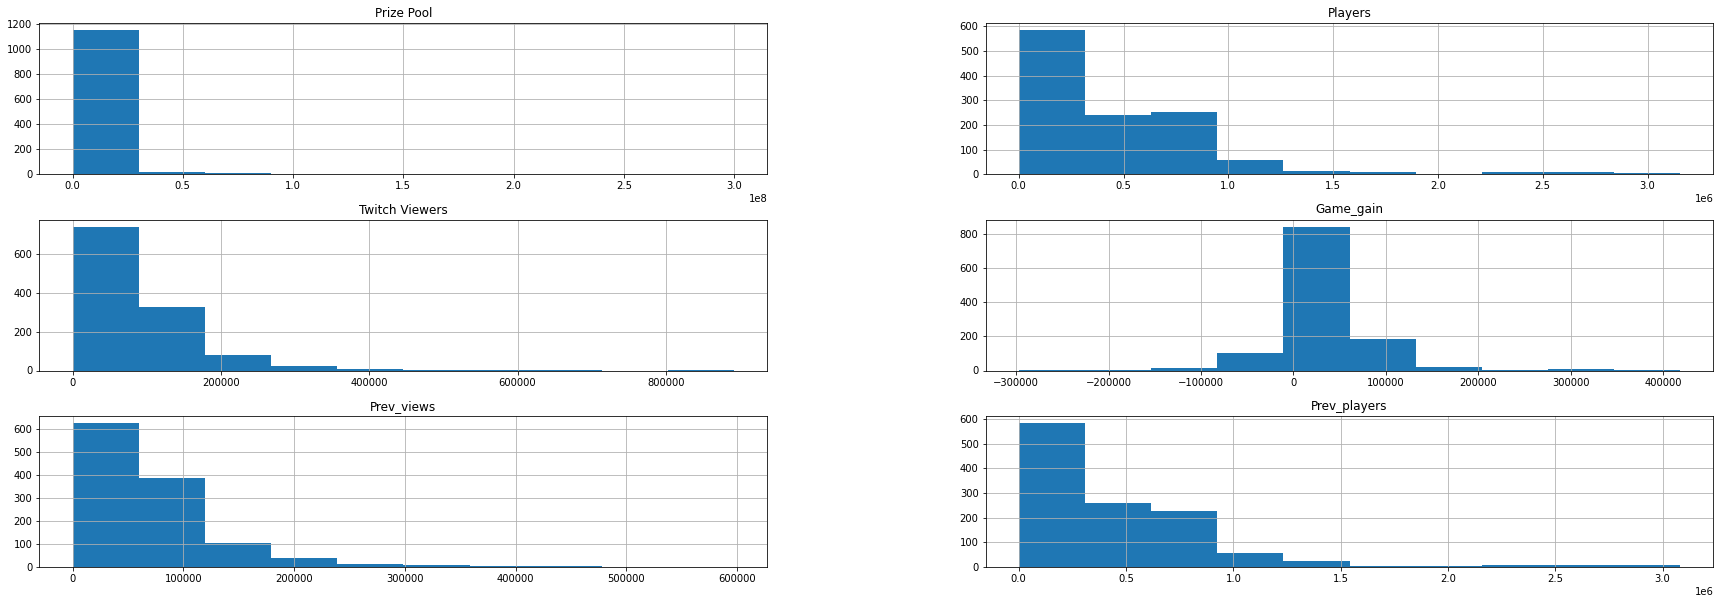

In [397]:
final_frame.hist(column = Numerical_columns, figsize=(30,10), ylabelsize=10, xlabelsize = 10)

All columns apart from Game_gain are all skewed left so I will try to apply a transform to the data to have it more normally ditributed which could lead to better results in our model. Prev_views and Prev_players look like they are represting quite similar date so I would be suprised to see a strong correlation there and so one might have to be dropped. 

In [398]:
#performing some transforms on the data to get a more normal distribution for the data which may lead to a perfomance increase in the model 
stats.boxcox(final_frame['Prize Pool'])[0]

array([10.31337776, 12.62487392, 12.62487392, ..., 14.72450987,
       14.68946432, 14.69519836])

array([[<AxesSubplot:title={'center':'Prize Pool'}>,
        <AxesSubplot:title={'center':'Players'}>],
       [<AxesSubplot:title={'center':'Twitch Viewers'}>,
        <AxesSubplot:title={'center':'Game_gain'}>],
       [<AxesSubplot:title={'center':'Prev_views'}>,
        <AxesSubplot:title={'center':'Prev_players'}>]], dtype=object)

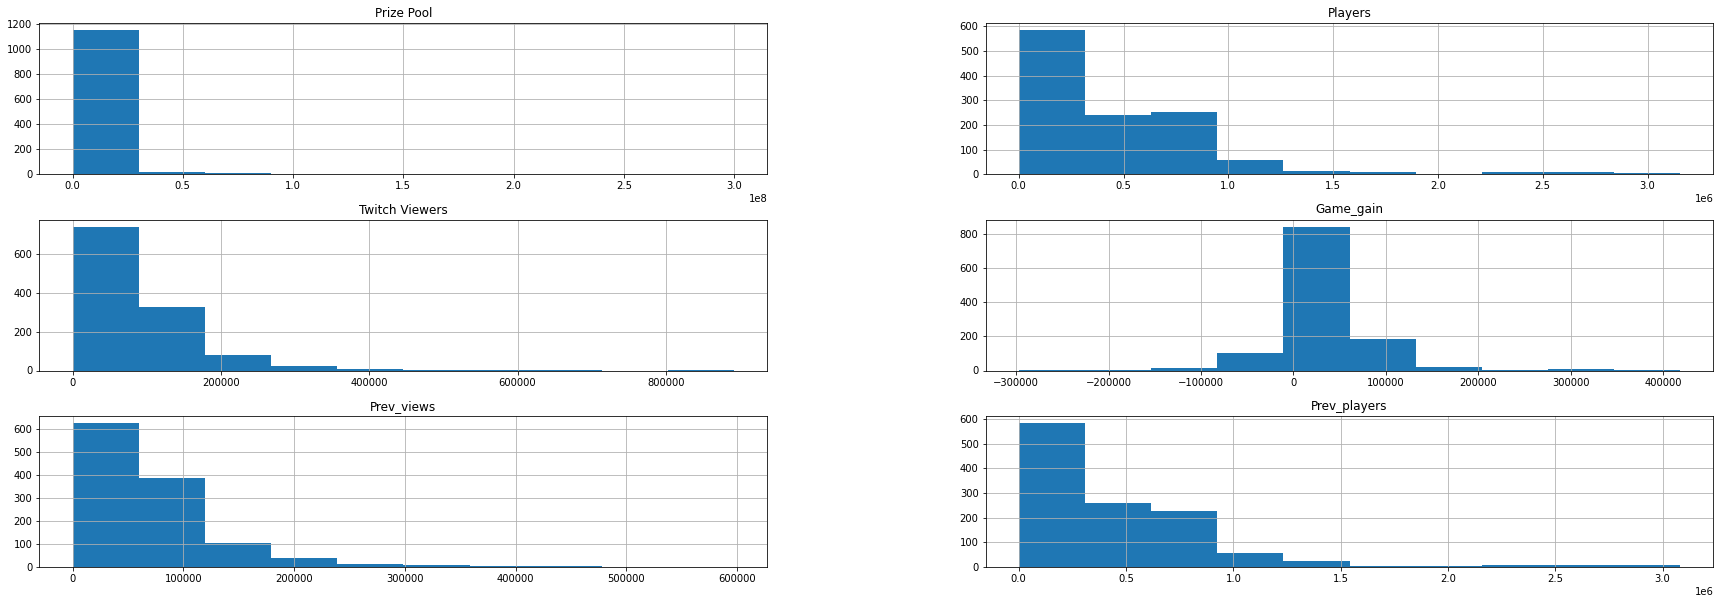

In [399]:
final_frame.hist(column = Numerical_columns, figsize=(30,10), ylabelsize=10, xlabelsize = 10)

In [400]:
final_frame.describe()


,DateTime,Tour_days,Prize Pool,Players,Twitch Viewers,Game_gain,Twitch_gain,Prev_views,Prev_players
count,1183.000000,1183.000000,1.183000e+03,1.183000e+03,1183.000000,1183.000000,1183.000000,1183.000000,1.183000e+03
mean,7.171598,2.349112,7.153120e+06,4.327075e+05,81476.622147,21236.252747,0.505495,65669.572274,4.238324e+05
std,3.407736,1.254035,1.592066e+07,5.007268e+05,83361.743356,54317.882281,0.500181,68084.193045,4.919045e+05
min,1.000000,1.000000,2.000000e+03,1.000000e+00,0.000000,-297184.000000,0.000000,0.000000,1.000000e+00
25%,4.000000,1.000000,2.235460e+05,5.338200e+04,15843.000000,-535.000000,0.000000,8698.500000,5.231550e+04
50%,7.000000,2.000000,1.932000e+06,3.952130e+05,65965.000000,1468.000000,1.000000,57022.000000,3.863610e+05
75%,10.000000,3.000000,9.250000e+06,6.655490e+05,116958.000000,42986.000000,1.000000,90884.500000,6.377000e+05
max,12.000000,5.000000,3.000000e+08,3.156713e+06,892155.000000,418620.000000,1.000000,597309.000000,3.082953e+06


Here we can see that Twitch Viewers has an empty viewer count on some days as min = 0 which I highly doubt is a true value for a game steaming on twitch so will need to be removed. 

In [401]:
final_frame.drop(final_frame.loc[final_frame['Twitch Viewers'] == 0].index, inplace=True)

In [402]:
final_frame.describe()

,DateTime,Tour_days,Prize Pool,Players,Twitch Viewers,Game_gain,Twitch_gain,Prev_views,Prev_players
count,1176.000000,1176.000000,1.176000e+03,1.176000e+03,1176.000000,1176.000000,1176.000000,1176.000000,1.176000e+03
mean,7.151361,2.353741,7.191066e+06,4.352832e+05,81961.602041,21362.663265,0.508503,66060.462585,4.263552e+05
std,3.406509,1.254386,1.596030e+07,5.010978e+05,83371.434367,54454.628134,0.500140,68097.198634,4.922753e+05
min,1.000000,1.000000,2.000000e+03,1.000000e+00,117.000000,-297184.000000,0.000000,0.000000,1.000000e+00
25%,4.000000,1.000000,2.207920e+05,5.404775e+04,16434.250000,-549.750000,0.000000,8842.000000,5.262450e+04
50%,7.000000,2.000000,1.975000e+06,4.025660e+05,66094.500000,1507.000000,1.000000,57360.500000,3.990565e+05
75%,10.000000,3.000000,9.260825e+06,6.656310e+05,117524.750000,43365.750000,1.000000,91151.250000,6.382940e+05
max,12.000000,5.000000,3.000000e+08,3.156713e+06,892155.000000,418620.000000,1.000000,597309.000000,3.082953e+06


After removing the values we get a more appropriate minimum viewer count of 117 which is reasonable as it could be for one of the less popular games on a quite month. 

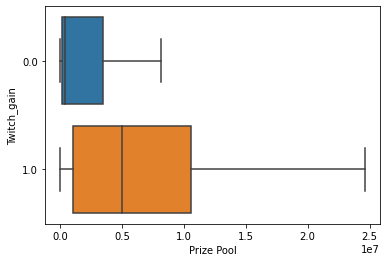

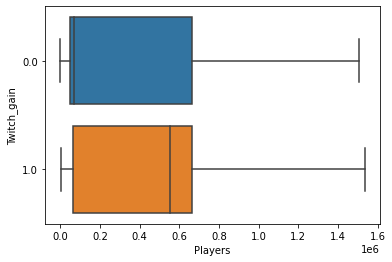

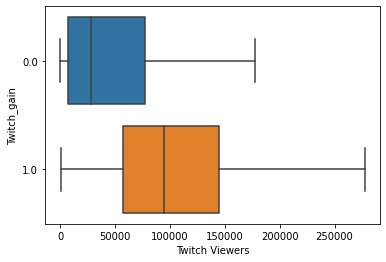

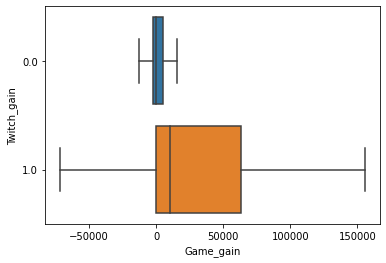

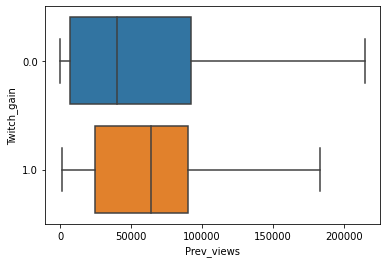

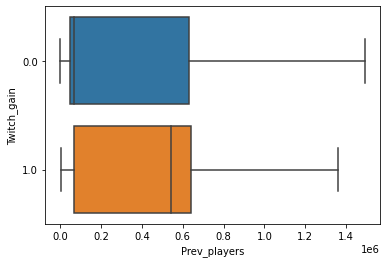

In [403]:
for col in Numerical_columns:
    sns.boxplot(y = final_frame['Twitch_gain'].astype('category'), x = col, data=final_frame, showfliers=False)
    plt.show()

From the box plots we can see that prev_players and players are quite evenly distributed between the twitch gain target meaning they likely won't be good predictors and so those columns will be dropped. All over values look like they may have enough variationin the data to become good predictors. Prev_views also although have some variation in data there isn't a great amount so it might not lead to being a good predictor.

In [404]:
#Drop the two unrequired columns
final_frame.drop(columns=['Prev_players', 'Players'], inplace=True)

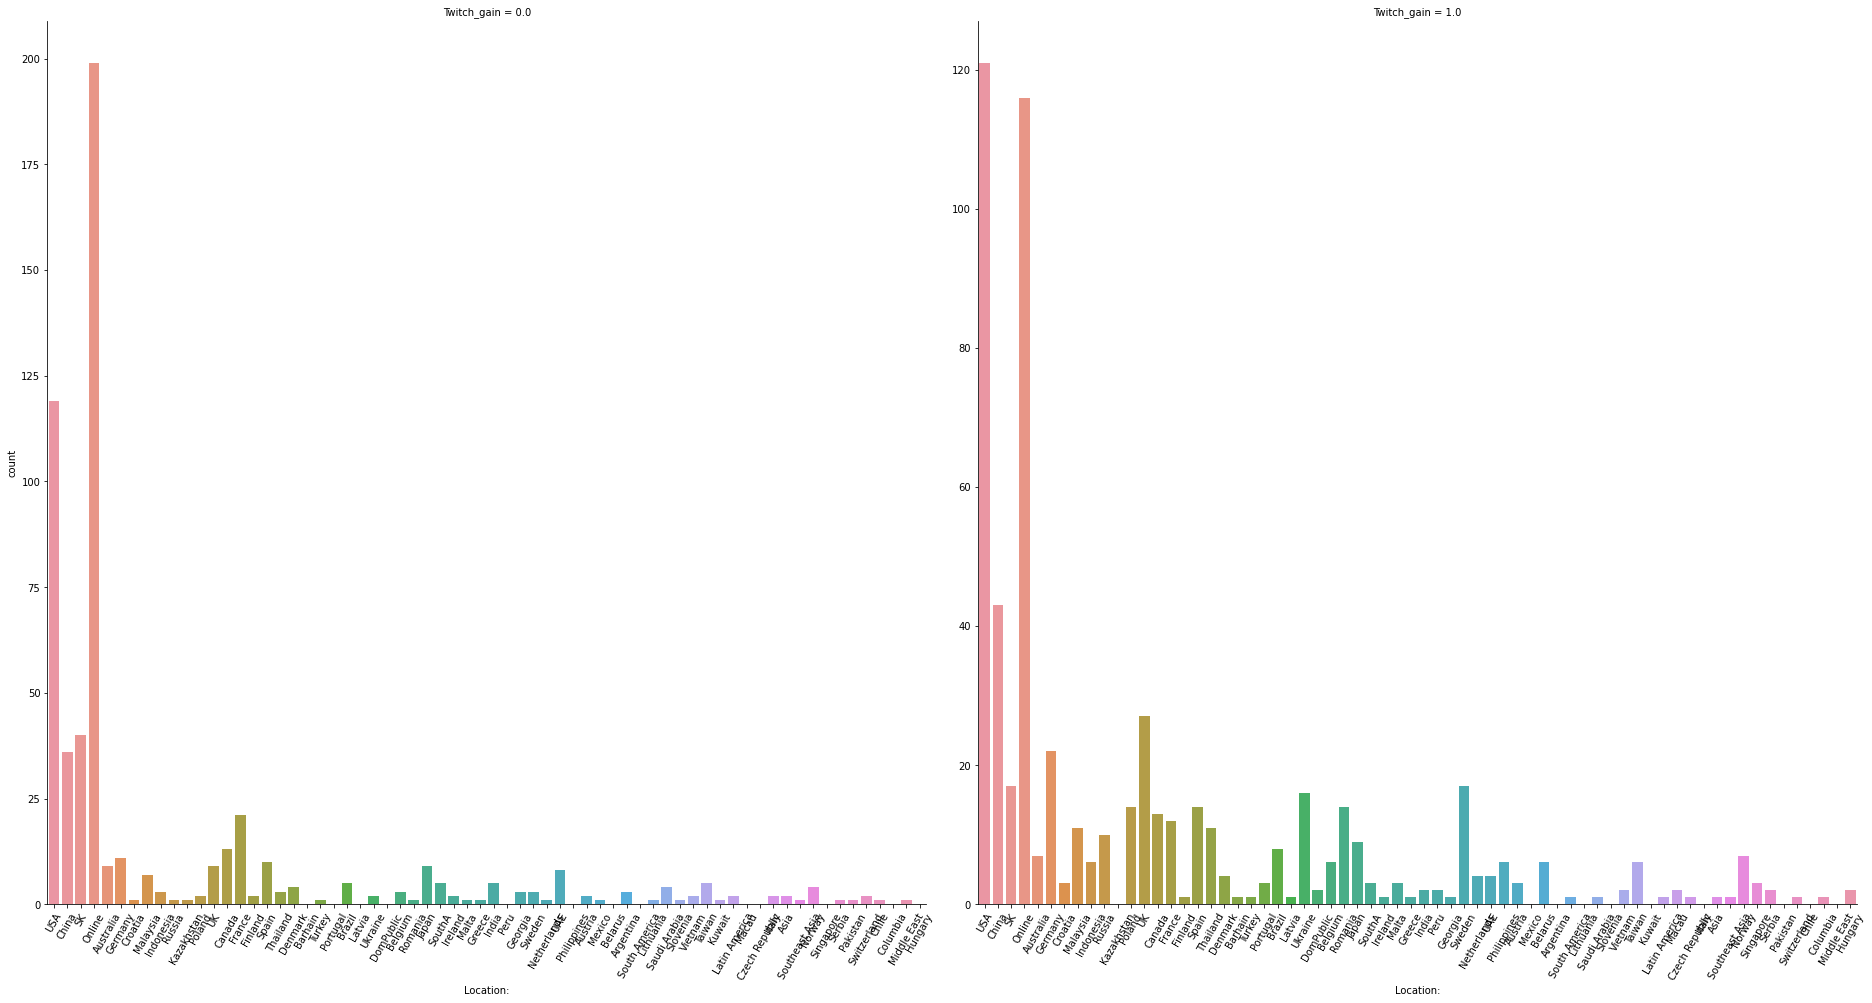

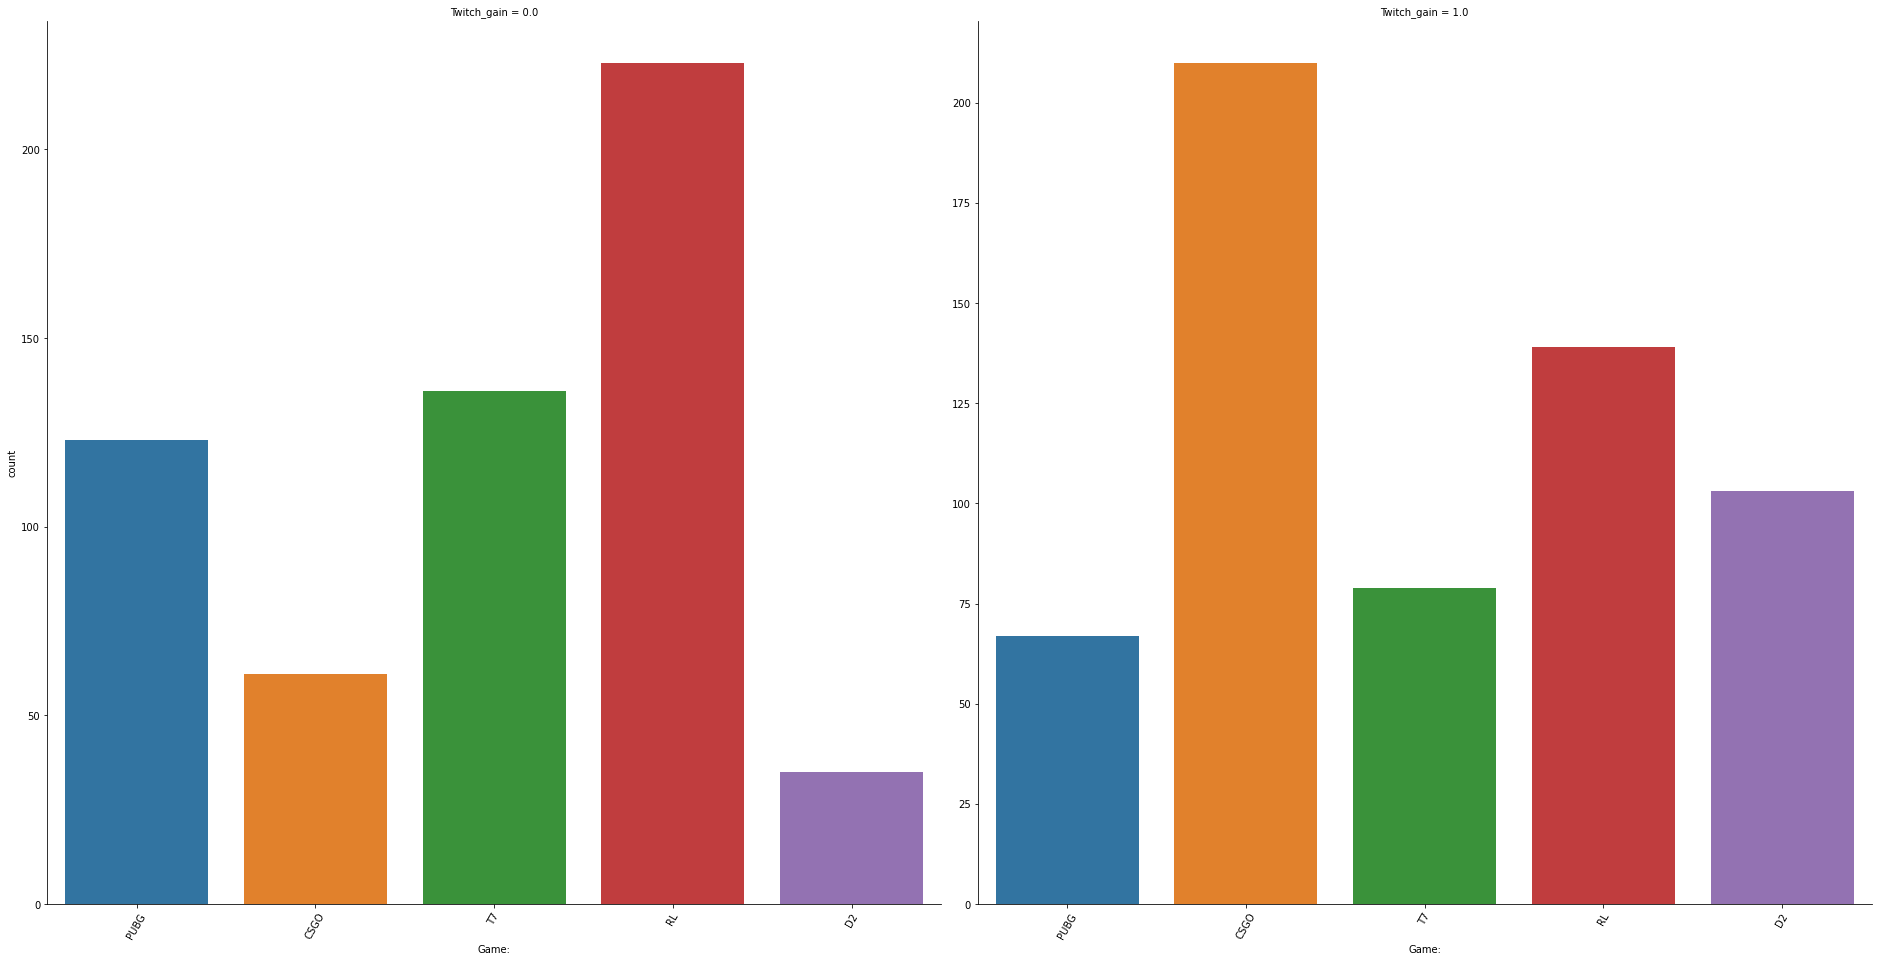

In [405]:
#create category plots for Games and Locations to further investigate the data.
for col in final_frame.select_dtypes(include='object'):
    category_graph = sns.catplot(x = col, kind='count', col ='Twitch_gain', data=final_frame, height=13, sharey=False)
    category_graph.set_xticklabels(rotation=60)

For the country categorical data there seems to be good variation in all the country apart from the USA and Online tournament which may lead to them being oversampled when creating the model this might be solved later on with varaible reduction.
The Game categories seem to have a better spread of the values which seems to suggest that games might be a good predictor. 

In [406]:
#final_frame['Location:'] = final_frame['Location:'].astype('category').cat.codes
game_dum = pd.get_dummies(final_frame['Game:'], prefix='Game' , dtype=float)
loc_dum = pd.get_dummies(final_frame['Location:'], prefix='Loc' , dtype=float)
final_frame = pd.concat([final_frame, game_dum], axis=1)
final_frame = pd.concat([final_frame, loc_dum], axis=1)
final_frame.drop(columns=['Game:', 'Location:'], inplace=True)


We will be one hot encoding the Location and Game variables for use when training our final mode, did try label encoding the countries but seemed to get better results with one hot encoding.

In [407]:
#Convert the remaning columns all to floats for use in the model. 
Int_cols = ['DateTime', 'Tour_days']
final_frame[Int_cols] = final_frame[Int_cols].astype(float)

<AxesSubplot:>

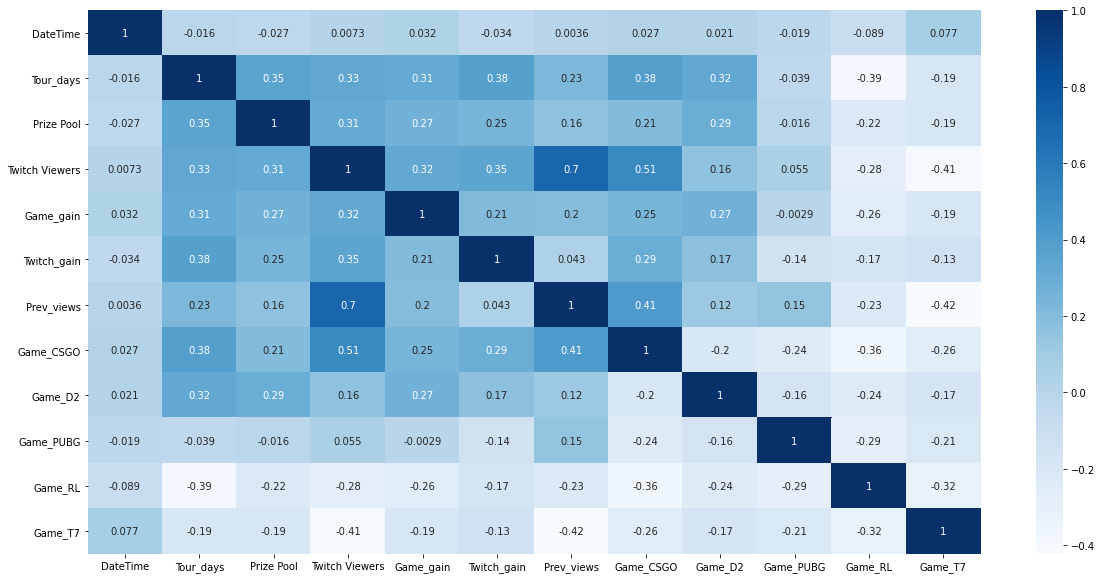

In [408]:
#Create our heatmap to check for correlation between variables.

cor = final_frame.corr()
plt.figure(figsize = (20,10))
sns.heatmap(cor.iloc[0:12,0:12], annot = True, cmap='Blues')

Here we can see a strong correlation between Twitch Viewers and Prev_views and from previous analyse from the box plots previous views will be dropped as it had less variation in it's data so is likely a worse predictor. 

In [409]:
final_frame.drop(columns=['Prev_views'], inplace=True)

<AxesSubplot:>

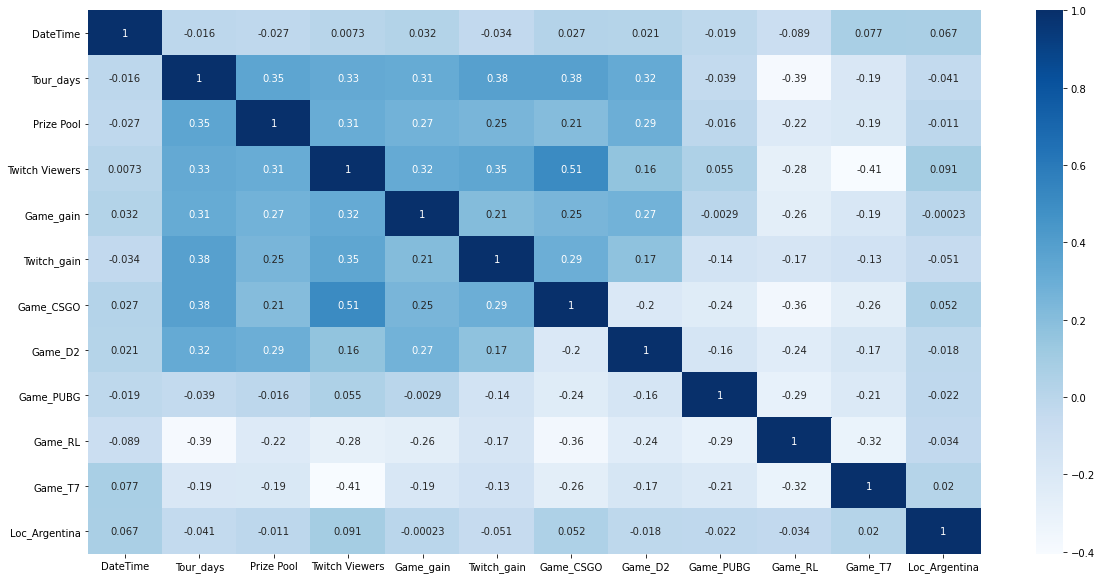

In [410]:
cor = final_frame.corr()
plt.figure(figsize = (20,10))
sns.heatmap(cor.iloc[0:12,0:12], annot = True, cmap='Blues')


Our model seems to have much more reasonable levels of correlation in its data now, though there is quite a strong correlation between Twitch Viewers and Prize Pool = 0.56 and Prize Pool and Tour days = 0.58. These varaibles will be important predictors for the stakeholders when deciding where to base tournaments so I will leave them in at the moment. If this leads to overfitting of the model then dropped some of these values will need to be revisited.  

In [411]:
def reduce_variables(dataframe, target):
    final_frame.columns = final_frame.columns.str.replace(' ', '_')
    target_string = target + " ~ "
    all_columns = dataframe.columns.tolist()  
    all_columns.remove(target)
    variables = " + ".join(all_columns)
    full_string =  target_string  + variables
    
    model_fit = smf.ols(full_string, data=dataframe).fit()
    
    pvalues = model_fit.pvalues
    pvalues = pvalues.drop("Intercept")
    
    max_p = pvalues.idxmax() 
    alpha = 0.05
       
    while pvalues.max() > alpha:
        max_p = pvalues.idxmax()
        all_columns.remove(max_p)
        variables = " + ".join(all_columns)
        full_string = target_string + variables
        
        model = smf.ols(full_string, data=dataframe).fit()
        pvalues = model.pvalues
        pvalues = pvalues.drop("Intercept")

    return model, full_string

final_model, complete_string = reduce_variables(final_frame, 'Twitch_gain')
print(complete_string)
print(final_model.summary())

Twitch_gain ~ Tour_days + Prize_Pool + Twitch_Viewers + Game_PUBG + Loc_Argentina + Loc_China + Loc_India + Loc_Online + Loc_Philippines + Loc_SK + Loc_Thailand
                            OLS Regression Results                            
Dep. Variable:            Twitch_gain   R-squared:                       0.255
Model:                            OLS   Adj. R-squared:                  0.248
Method:                 Least Squares   F-statistic:                     36.14
Date:                Tue, 15 Jun 2021   Prob (F-statistic):           6.38e-67
Time:                        07:40:48   Log-Likelihood:                -680.60
No. Observations:                1176   AIC:                             1385.
Df Residuals:                    1164   BIC:                             1446.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t 

In [412]:
#Create our final dataframe for creating the model with the required variables. 
model_frame = final_frame[['Twitch_gain' ,'Tour_days', 'Twitch_Viewers', 'Prize_Pool', 'DateTime']].copy()

In [413]:
#Pop our target column for creating our model
y = model_frame.pop('Twitch_gain')

In [432]:
# Define a fucntion for calculating the fm score for each threshold of our logistic model which returns the fm score. 
def calculate_fm_score(y_value, y_pred_value):

    tn, fp, fn, tp = confusion_matrix(y_value, y_pred_value).ravel()

    print(tn, fp, fn, tp)
    Condition_pos = tp + fn
    Condition_neg = tn + fp

    Total_pop = tp + fp + tn + fn
    Prevalence = Condition_pos/Total_pop

    m = ((1-Prevalence)/(Prevalence))*((fp - tn)/(fn - tp))
    print(f"m is:{m}")
    Tpr = tp / Condition_pos
    Fpr = fp / Condition_neg

    fm = Tpr - (m*Fpr)

    return fm

In [448]:
# split the data into the train and test sets before training and testing the model.
X_train, X_test, Y_train, Y_test = train_test_split(model_frame, y, test_size=0.3, random_state=10)
X_test, X_val, Y_test, Y_val = train_test_split(X_test, Y_test, test_size=0.5, random_state=10)

#intialise the scaler and logistic regression model. 
log_mod = LogisticRegression()
scaler = StandardScaler()

# scale our data using the standardisation our data has a large variation in its data ranges.
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_val - scaler.transform(X_val)
log_mod.fit(X_train, Y_train)

#save our predicted probabilites into a dataframe before applying our threshold. 
pred_proba_df = pd.DataFrame(log_mod.predict_proba(X_train))

best_FM = 0
#create a range of thresholds to analyse for to get our best fm score.
threshold_list = np.arange(0.1,0.6,0.01)
for threshold in threshold_list:
    
    print (f'\n******** For threshold = {threshold} ******')
    #set the prediction values to 1 or leave as 0 based on the current threshold value. 
    Y_train_pred = pred_proba_df.applymap(lambda x: 1 if x > threshold else 0)
    test_accuracy = metrics.accuracy_score(Y_train.to_numpy().reshape(Y_train.to_numpy().size,1),
                                           Y_train_pred.iloc[:,1].to_numpy().reshape(Y_train_pred.iloc[:,1].to_numpy().size,1))
    #print the current training accuracy                                        
    print('Our testing accuracy is {}'.format(test_accuracy))

    y_hat_train = (Y_train_pred.iloc[:,1].to_numpy().reshape(Y_train_pred.iloc[:,1].to_numpy().size,1))
    
    FM = calculate_fm_score(Y_train, y_hat_train)

    print(f"The current fm score is : {FM}")

    #display ou
    print(confusion_matrix(Y_train.to_numpy().reshape(Y_train.to_numpy().size,1),
                           Y_train_pred.iloc[:,1].to_numpy().reshape(Y_train_pred.iloc[:,1].to_numpy().size,1)))

    #If the fm score is increase from the previous score then update the best_FM variable to keep the best current fm score. 
    #Also save the threshold and accuracy for that given fm score. 
    if FM > best_FM:
        best_FM= FM
        Current_best_threshold = threshold
        Current_best_acc = test_accuracy
        best_y_hat = y_hat_train

    print(best_FM)


******** For threshold = 0.1 ******
Our testing accuracy is 0.520048602673147
0 395 0 428
m is:-0.8517392348676741
The current fm score is : 1.851739234867674
[[  0 395]
 [  0 428]]
1.851739234867674

******** For threshold = 0.11 ******
Our testing accuracy is 0.520048602673147
0 395 0 428
m is:-0.8517392348676741
The current fm score is : 1.851739234867674
[[  0 395]
 [  0 428]]
1.851739234867674

******** For threshold = 0.12 ******
Our testing accuracy is 0.520048602673147
0 395 0 428
m is:-0.8517392348676741
The current fm score is : 1.851739234867674
[[  0 395]
 [  0 428]]
1.851739234867674

******** For threshold = 0.13 ******
Our testing accuracy is 0.520048602673147
0 395 0 428
m is:-0.8517392348676741
The current fm score is : 1.851739234867674
[[  0 395]
 [  0 428]]
1.851739234867674

******** For threshold = 0.13999999999999999 ******
Our testing accuracy is 0.520048602673147
0 395 0 428
m is:-0.8517392348676741
The current fm score is : 1.851739234867674
[[  0 395]
 [  0 

In [439]:
logistic_regression = sm.Logit(y,sm.add_constant(model_frame))
result = logistic_regression.fit()
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.572121
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:            Twitch_gain   No. Observations:                 1176
Model:                          Logit   Df Residuals:                     1171
Method:                           MLE   Df Model:                            4
Date:                Tue, 15 Jun 2021   Pseudo R-squ.:                  0.1744
Time:                        08:07:52   Log-Likelihood:                -672.81
converged:                       True   LL-Null:                       -814.97
Covariance Type:            nonrobust   LLR p-value:                 2.617e-60
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -1.6141      0.204     -7.912      0.000      -2.014      -1.214
Tour_days        

For our coefficents of the Logistic Regression model these can be expressed as:

Tour_days: For an increase of 1 tour day we can expect a 0.458% increased likelyhood of getting the required 10k viewers holding all other values constant.
Interestingly in crease in twitch viewers from the previous years and prize pool actually decrease the likelyhood of gaining the 10k viewers but only by a small margin. This points to previous years twitch viewers and the prize pool not being as impactful an indicator as I previously expected.


In [445]:
pred_proba_df = pd.DataFrame(log_mod.predict_proba(X_test))

y_hat_test = log_mod.predict(X_test)

print('Our test accuracy without updated thresholds is {}'.format(test_accuracy))

Y_test_pred = pred_proba_df.applymap(lambda x: 1 if x >0.45 else 0)
test_accuracy = metrics.accuracy_score(Y_test.to_numpy().reshape(Y_test.to_numpy().size,1),
                                           Y_test_pred.iloc[:,1].to_numpy().reshape(Y_test_pred.iloc[:,1].to_numpy().size,1))
print('Our testing accuracy is with updated threshold is {}'.format(test_accuracy))

Our test accuracy without updated thresholds is 0.7223796033994334
Our testing accuracy is with updated threshold is 0.7478753541076487


We can see here that using an optimised threshold has increased the fit on the training set by 2.56% showing that an optimised threshold can improve our test score. 

In [418]:
# create our decision tree classifier
dec_tree = DecisionTreeClassifier()

#set the parameters to used in a gridsearch for the decsion tree
param_dict = {"criterion":['gini','entropy'],
"max_depth":range(1,10),
"min_samples_split":range(2,10),
"min_samples_leaf":range(1,5)
}

#run the grid search to predict the best parameters for our model. 
grid = GridSearchCV(dec_tree, param_grid=param_dict, cv=10, verbose=1, n_jobs=1)
grid.fit(X_train, Y_train)


Fitting 10 folds for each of 576 candidates, totalling 5760 fits


GridSearchCV(cv=10, estimator=DecisionTreeClassifier(), n_jobs=1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': range(1, 10),
                         'min_samples_leaf': range(1, 5),
                         'min_samples_split': range(2, 10)},
             verbose=1)

In [419]:
#print the best hyperparameters giving the best decision tree results.
grid.best_estimator_

DecisionTreeClassifier(criterion='entropy', max_depth=5, min_samples_leaf=4,
                       min_samples_split=9)

In [420]:
grid.best_score_

0.6986335586247427

Even though close is seem that the decsion tree is performing worse than the Logistical Regression even after running a gridsearch and the logistical regression currently has no optimisation.

No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.791


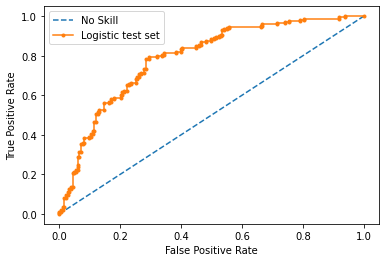

In [421]:
ns_probs = [0 for _ in range(len(Y_test))]
lr_probs = log_mod.predict_proba(X_test)

lr_probs = lr_probs[:, 1]
ns_auc = roc_auc_score(Y_test, ns_probs)
lr_auc = roc_auc_score(Y_test, lr_probs)

print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Logistic: ROC AUC=%.3f' % (lr_auc))

ns_fpr, ns_tpr, _ = roc_curve(Y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(Y_test, lr_probs)

plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(lr_fpr, lr_tpr, marker='.', label='Logistic test set')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.legend()
# show the plot
plt.show()

Graphing the ROC curve we get an excellent area under the curve score of 0.791 showing that our model has some predictive power in determining how to configure the tournaments. 

In [462]:
cv = KFold(n_splits=5, random_state=10, shuffle=True)
val_score = cross_val_score(log_mod, X_val, Y_val, cv=cv, scoring='accuracy')
print(np.sum(val_score)/5)

0.52
